In [23]:
# 1 import part
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

In [24]:
# 2 Class Gen
def get_generator_block(input_dim, output_dim):

    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

class Generator(nn.Module):
    def __init__(self, z_dim=64, im_dim=(512, 14, 14), hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim[0] * im_dim[1] * im_dim[2]),
            nn.Sigmoid()
        )
    
    def forward(self, noise):
        return self.gen(noise).view(noise.shape[0], *im_dim)

In [25]:
# 3 Class Disc
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
         nn.Linear(input_dim, output_dim), #Layer 1
         nn.LeakyReLU(0.2, inplace=True)
    )

class Discriminator(nn.Module):
    def __init__(self, im_dim=(512, 14, 14), hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(np.prod(im_dim), hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        return self.disc(image.view(image.shape[0], -1))

In [26]:
# 4 func getLoss
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)

    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
   
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

In [27]:
# 5 func getLoss
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

    return gen_loss

In [28]:
# 6 func getNoise
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim,device=device)

In [29]:
# 7 func visualize
def visualize_tsne(all_feature, RFtype):
    # 平均池化降维，将特征向量从 (421, 512, 14, 14) 降维到 (421, 512)
    # all_feature = np.mean(all_feature, axis=(2, 3))
    if RFtype == "real":
        # all_feature = np.mean(all_feature, axis=(0, 1))
        pass
    else:
        all_feature = np.mean(all_feature, axis=(2, 3))

    # 执行t-SNE降维
    tsne = TSNE(n_components=2, random_state=42)
    feature_tsne = tsne.fit_transform(all_feature)

    # Visualize t-SNE results
    plt.scatter(feature_tsne[:, 0], feature_tsne[:, 1], s=1)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title(RFtype)
    plt.show()

In [30]:
# 8 hyperperameter and so on
z_dim = 128
batch_size = 128
lr = 0.00001
device = 'cpu'

criterion = nn.BCEWithLogitsLoss()
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

im_dim=(512, 14, 14)

In [31]:
# 9 dataset
"""
data = np.load("my_npz.npz")
all_feature = data['f_map']
print(all_feature.shape)
(421, 512, 14, 14)

特征向量的形状 (421, 512, 14, 14) 表示特征图数据具有四个维度,
分别是 (样本数, 通道数, 高度, 宽度)。具体来说,
样本数: 421, 表示你的数据集中有421个样本。
通道数: 512, 表示每个特征图有512个通道。
高度: 14, 表示每个特征图的高度为14个像素。
宽度: 14, 表示每个特征图的宽度为14个像素。
"""
class FeatureDataset(Dataset):
    def __init__(self, file_path):
        self.data = np.load(file_path)['f_map']  # 加载 npz 文件的特征图数据

    def __len__(self):
        return len(self.data)  # 返回数据集的大小

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.tensor(sample, dtype=torch.float)  # 转换为 PyTorch 张量

# 修改 DataLoader 的数据集为特征图的自定义 Dataset
# (2546, 512, 14, 14)
path1 = '../../Data/iccnn/vgg16/16_vgg_voc_multi_iccnn_200.npz'#multi_iccnn
# (421, 512, 14, 14)
path3 = '../../Data/iccnn/basic_fmap/vgg_download/vgg_voc_bird_lame1_c5_ep2499.npz'#bird_iccnn(论文用)
# (2546, 2208, 7, 7)
path4 = '../../Data/iccnn/densenet161/161_densenet_voc_multi_iccnn.npz'#multi_iccnn
dataset = FeatureDataset(path1)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Step 0: Generator loss: 0.017094029878315174, discriminator loss: 0.0004129385085482346


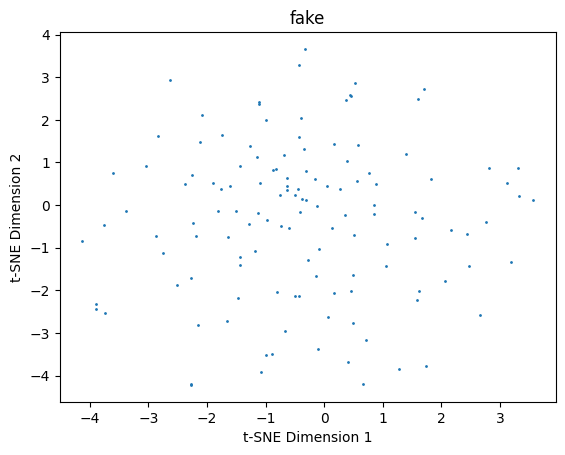

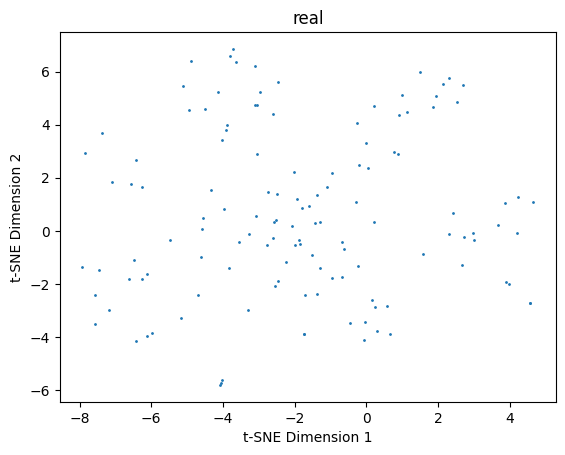

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Step 190: Generator loss: 4.662847532724077, discriminator loss: 0.028199905416879206


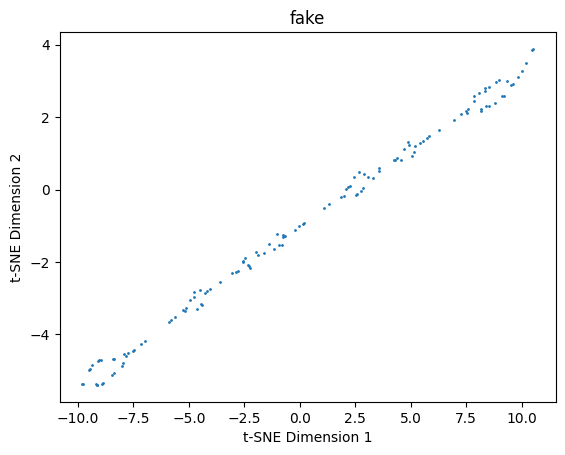

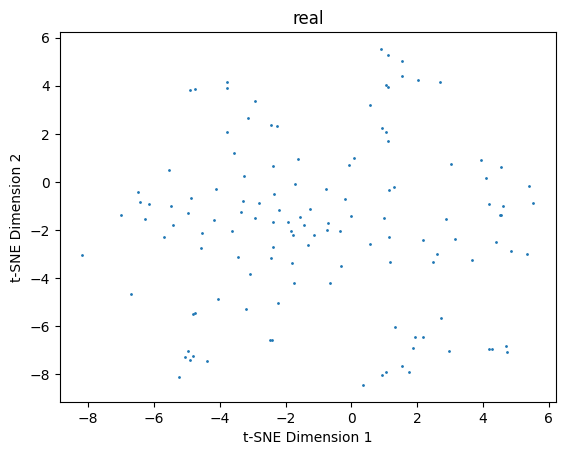

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Step 380: Generator loss: 5.6738270609002335, discriminator loss: 0.013159557853482273


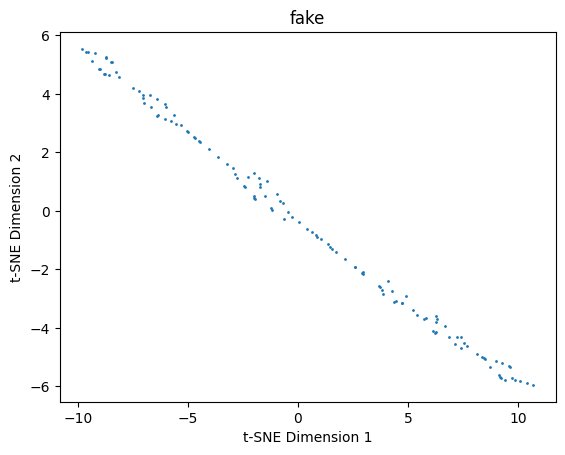

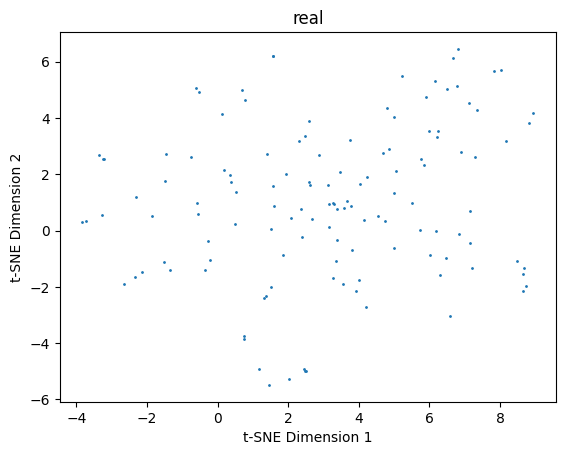

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Step 570: Generator loss: 5.634455899188392, discriminator loss: 0.010091096280436767


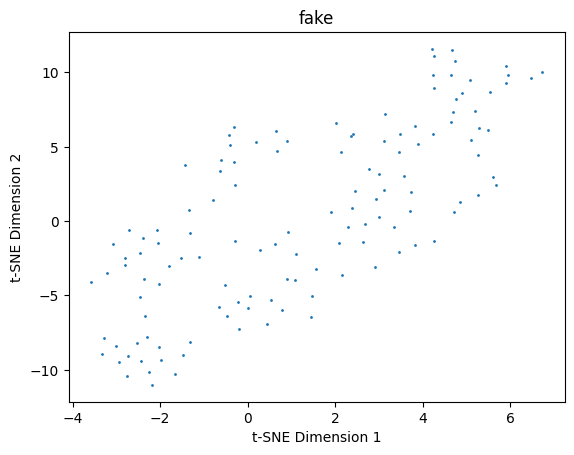

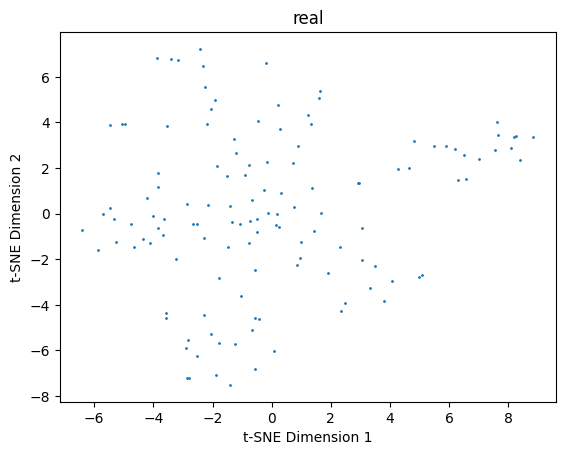

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Step 760: Generator loss: 5.912714401044347, discriminator loss: 0.014609920319267788


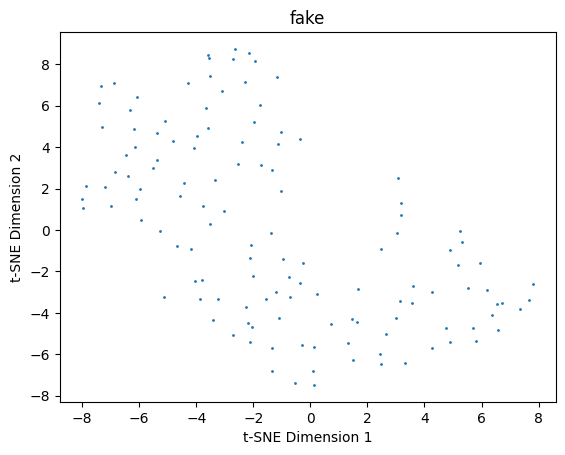

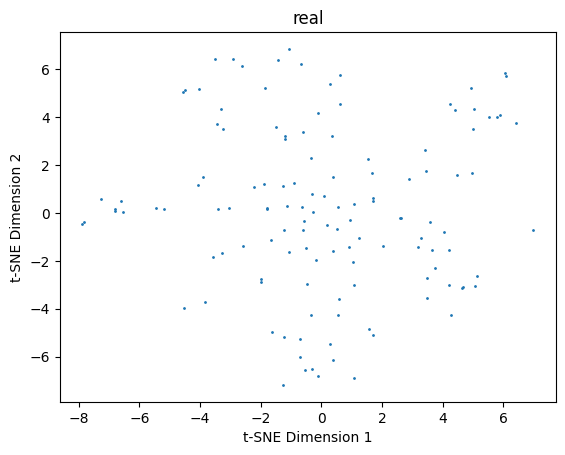

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Step 950: Generator loss: 5.251249082464922, discriminator loss: 0.03495609594607041


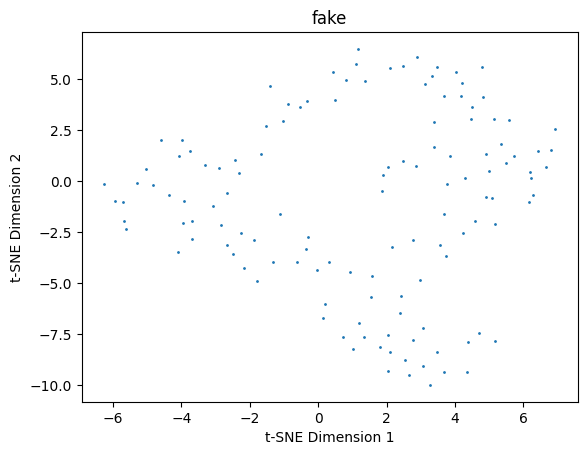

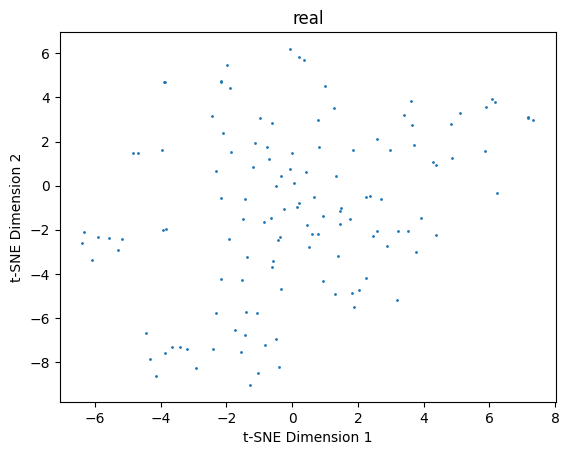

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Step 1140: Generator loss: 5.467681929939674, discriminator loss: 0.02072550321586037


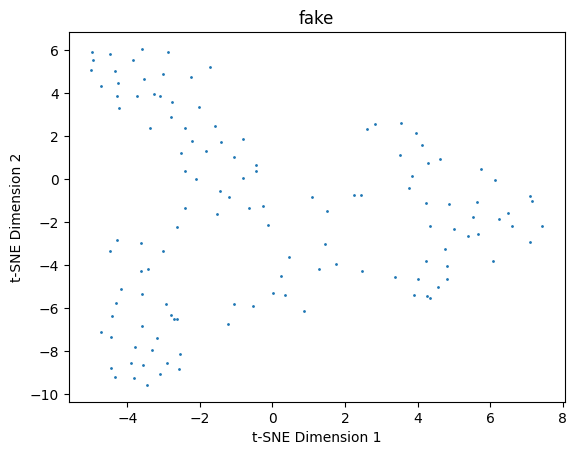

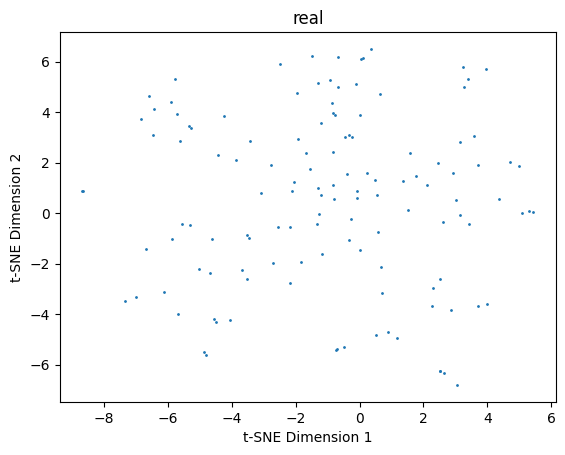

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Step 1330: Generator loss: 5.820615678084523, discriminator loss: 0.011726421240325035


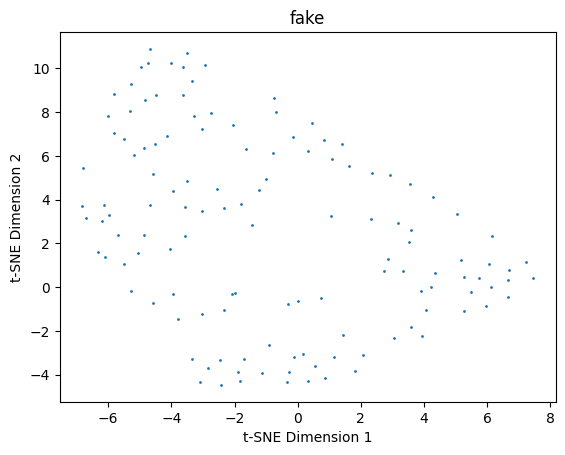

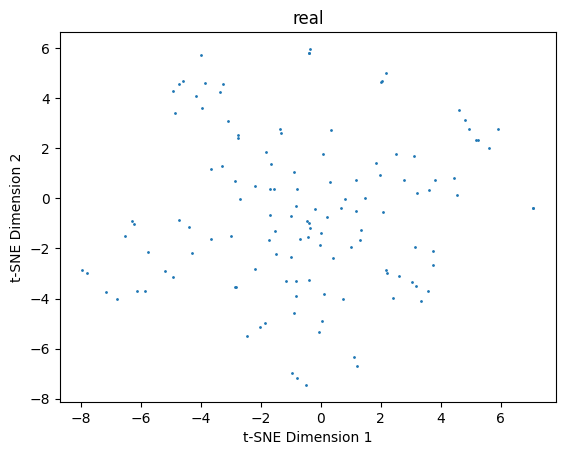

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Step 1520: Generator loss: 6.125611247514422, discriminator loss: 0.007146095871729285


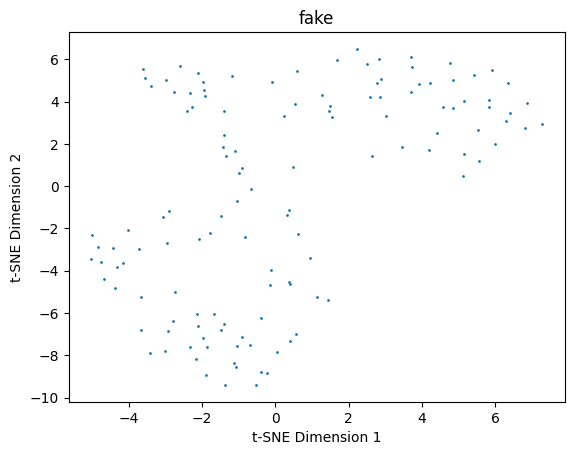

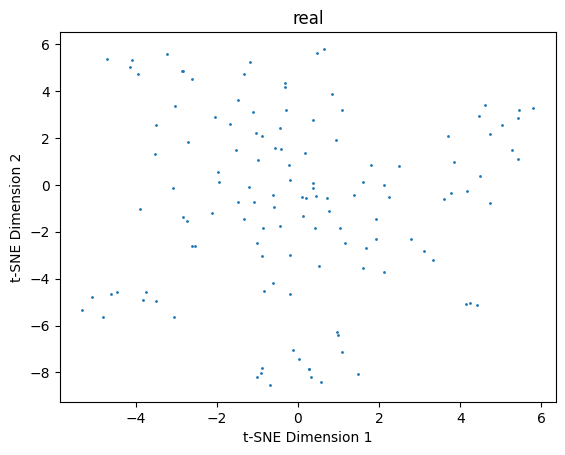

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Step 1710: Generator loss: 6.378591532456248, discriminator loss: 0.004829671565982466


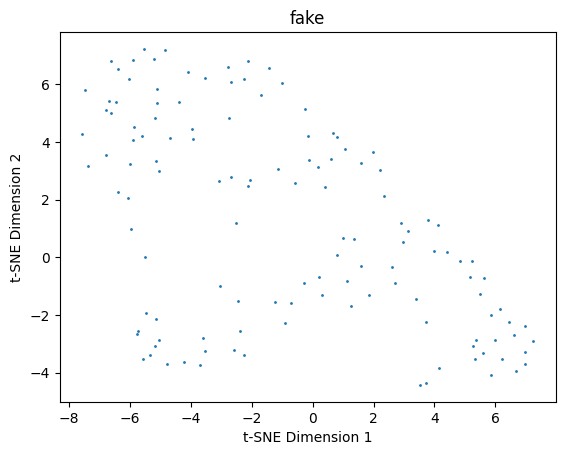

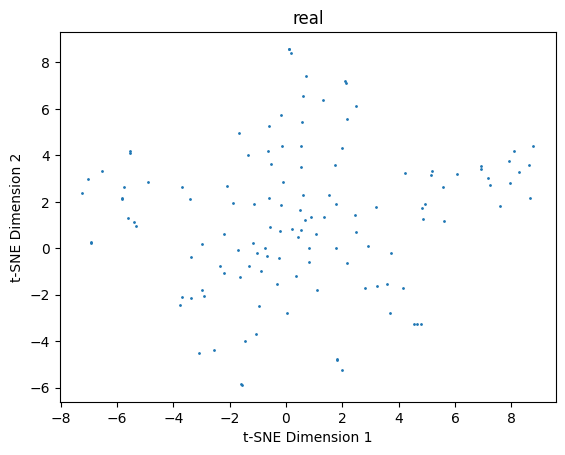

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Step 1900: Generator loss: 6.576372824217142, discriminator loss: 0.003408110933378339


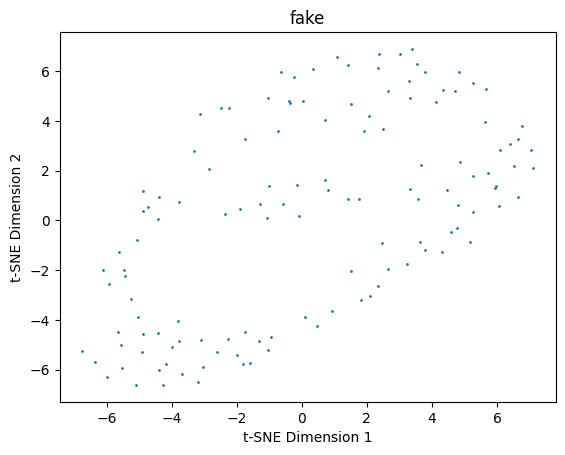

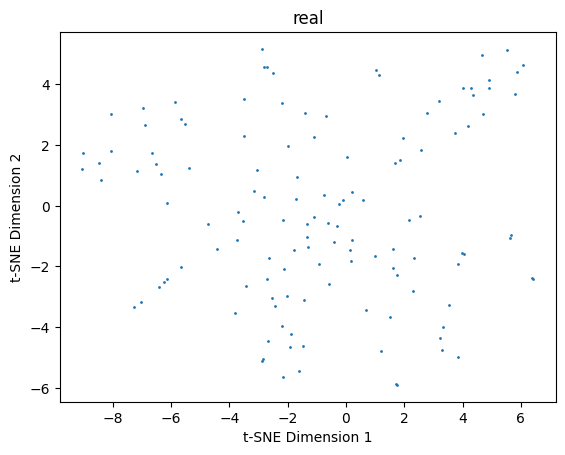

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [35]:
# 10 train
n_epochs = 100
display_step = 19 * 10

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False

for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        ### Update discriminator ###
        disc_opt.zero_grad()
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_opt.zero_grad()
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        # if cur_step % display_step == 0 and cur_step > 0:
        if cur_step % display_step == 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            fake_all_feature = fake.detach().cpu().numpy()
            real_all_feature = real.detach().cpu().numpy()
            visualize_tsne(fake_all_feature, "fake")
            visualize_tsne(real_all_feature, "real")
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
